# Climate modelling using a 1D energy balance model


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

import matplotlib
matplotlib.rcParams['font.family'] = 'serif'

In [2]:
#constants

sb = 5.670374E-8 # Stefan_Boltzman
hc = 3.5E8 # Heat Capacity per unit area of the Earth's surface with 100m water, assumed constant with latitude J.K^-1.m^-2
k = 0.5 # Thermal conductivity of Earth in North-South direction W.m^-2.K^-1
ir_trans = 0.6

In [3]:
t_end = 30 # years
N = 5000 # Number of time steps
dt = t_end/N

## Solving the heat differential equation

In [4]:
M = 50 # number of latitude steps
dx = 2/M # step in latitude
x = np.arange(-1,1.004, dx) # -1 is south pole

In [5]:
# Isolation variation with latitude
d = [422, 0, -180, 0, -70]
s = np.array(4*(d[0] + d[1]* x + d[2]*(x**2) + d[3]*(x**3) + d[4]*(x**4)))

In [6]:
# Albedo of earth at different latitudes.
a = [0.209, 0.016, 0.2619, -0.04, 0.1453]
albedo = np.array(a[0] + a[1]*x + a[2]*(x**2) + a[3]*x**3 + a[4]*x**4)

In [7]:
x_coefficient_1 = np.array((x**2 - 1)/(dx**2))
x_coefficient_2 = np.array(x/dx)

In [8]:
C1 = hc/k
C2 = (s * (1 - albedo))/(4*k)
C3 = ir_trans*(sb/k)
c = (3.156e7*dt)/C1

In [9]:
b1 = 2*c*x_coefficient_1
b2 = c*(x_coefficient_1 + x_coefficient_2)
b3 = c*(x_coefficient_2 - x_coefficient_1)
b4 = c*C2
b5 = c*C3

In [10]:
Tmp = np.ones(shape=(M + 1,N))
Tmp = Tmp * 287

In [11]:
#solving the heat transfer differential equation
for n in range(1, N - 1):
    for m in range(1,M): # misses m = 0, m = 50
        Tmp[m][n+1] = (Tmp[m][n]*(1 + b1[m])) - (Tmp[m+1][n]*b2[m]) + (Tmp[m-1][n]*b3[m])+ b4[m] - (b5*(Tmp[m][n]**4))
    Tmp[0][n+1] = ( 4*Tmp[1][n+1] - Tmp[2][n+1] )/3
    Tmp[M][n+1] = ( 4*Tmp[M - 1][n+1] - Tmp[M-2][n+1] )/3

In [12]:
def temperature_time_series(_k, _ir_trans):
    C1 = hc/_k
    C2 = (s * (1 - albedo))/(4*k)
    C3 = _ir_trans*(sb/k)
    c = (3.156e7*dt)/C1
    
    b1 = 2*c*x_coefficient_1
    b2 = c*(x_coefficient_1 + x_coefficient_2)
    b3 = c*(x_coefficient_2 - x_coefficient_1)
    b4 = c*C2
    b5 = c*C3
    
    Tmp = np.ones(shape=(M + 1,N))
    Tmp = Tmp * 287
    for n in range(1, N - 1):
        for m in range(1,M): # misses m = 0, m = 50
            Tmp[m][n+1] = (Tmp[m][n]*(1 + b1[m])) - (Tmp[m+1][n]*b2[m]) + (Tmp[m-1][n]*b3[m])+ b4[m] - (b5*(Tmp[m][n]**4))
    
        Tmp[0][n+1] = ( 4*Tmp[1][n+1] - Tmp[2][n+1] )/3
        Tmp[M][n+1] = ( 4*Tmp[M - 1][n+1] - Tmp[M-2][n+1] )/3
    
    return Tmp

## The latitude temperature distibution

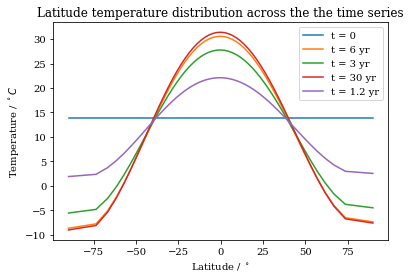

In [13]:
x[0] = round(x[0])
x[M] = round(x[M])
latitude = np.arcsin(x) * (180/math.pi)

plt.title(label='Latitude temperature distribution across the the time series')
plt.xlabel('Latitude / $^\circ$')
plt.ylabel('Temperature / $^\circ C$')
plt.plot(latitude, [Tmp[i][0] - 273.15 for i in range(M + 1)], label='t = 0')
plt.plot(latitude, [Tmp[i][1000] - 273.15 for i in range(M + 1)], label='t = 6 yr')
plt.plot(latitude, [Tmp[i][500] - 273.15 for i in range(M + 1)], label='t = 3 yr')
plt.plot(latitude, [Tmp[i][4999] - 273.15 for i in range(M + 1)], label='t = 30 yr')
plt.plot(latitude, [Tmp[i][200] - 273.15 for i in range(M + 1)], label='t = 1.2 yr')
plt.legend(bbox_to_anchor=(1,1), loc="upper right")


### Animated time series of the latitude temperature distibution

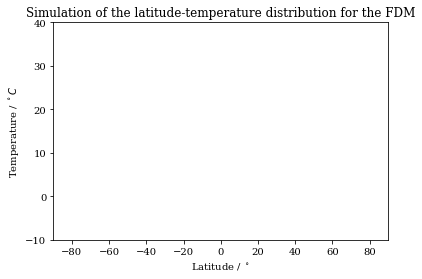

In [14]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = plt.axes(xlim=(-90, 90), ylim=(-10, 40))
ax.set_title('Simulation of the latitude-temperature distribution for the FDM')
ax.set_xlabel('Latitude / $^\circ$')
ax.set_ylabel('Temperature / $^\circ C$')
line, = ax.plot([], [], lw=3, color='black')

def init():
    line.set_data([], [])
    return line,
              
def animate(i):
    t = i * 50
    line.set_data(latitude, [Tmp[j][t] - 273.15 for j in range(M + 1)])
    line.set_label(f't = {t}')
    ax.legend()
    #fig.savefig(f'climate_{i}.png')
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=int(N/50),interval = 1)


#anim.save('climate.gif', writer='Pillow')

## Evolution of system temperature over time

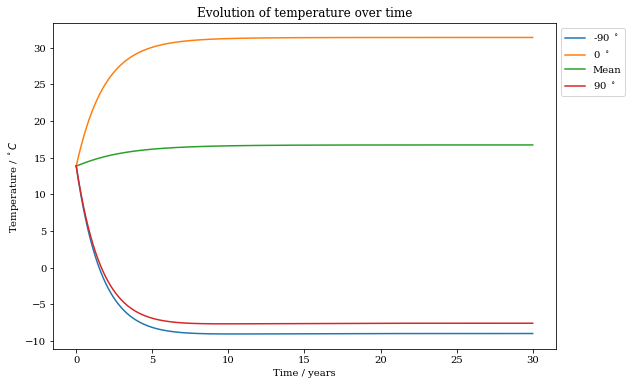

In [15]:
time_series = [((n/5000)*30) for n in range(0, N)]
plt.rcParams["figure.figsize"] = (9,6)
plt.title('Evolution of temperature over time')
plt.xlabel('Time / years')
plt.ylabel('Temperature / $^\circ C$')
plt.plot(time_series, Tmp[0] - 273.15, label='-90 $^\circ$')
plt.plot(time_series, Tmp[int(M/2)] - 273.15, label='0 $^\circ$')
plt.plot(time_series, np.mean(Tmp, axis=0) - 273.15, label='Mean')
plt.plot(time_series, Tmp[M] - 273.15, label="90 $^\circ$")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")



## North pole temperature over time with k dependence.


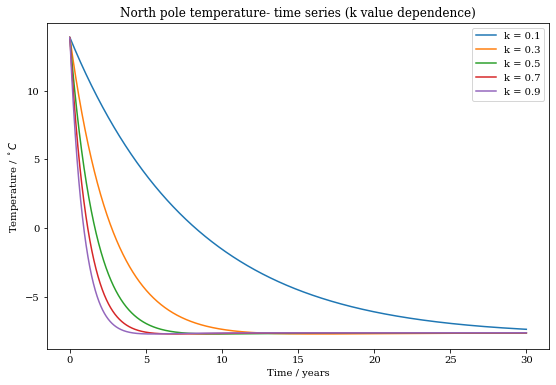

In [16]:
plt.title('North pole temperature- time series (k value dependence)')
plt.xlabel('Time / years')
plt.ylabel('Temperature / $^\circ C$')
for i in np.arange(0.1, 1.0, 0.2):
    plt.plot(time_series, temperature_time_series(_k = i, _ir_trans = 0.6)[M] - 273.15, label=f'k = {round(i, 1)}')
    
plt.legend()


## Polar comparision

In [17]:
transmission_temperature_series = []
k_values = np.arange(0.1,1.1,0.1)
for i in k_values:
    transmission_temperature_series.append([i, temperature_time_series(_k=i, _ir_trans = 0.6)])

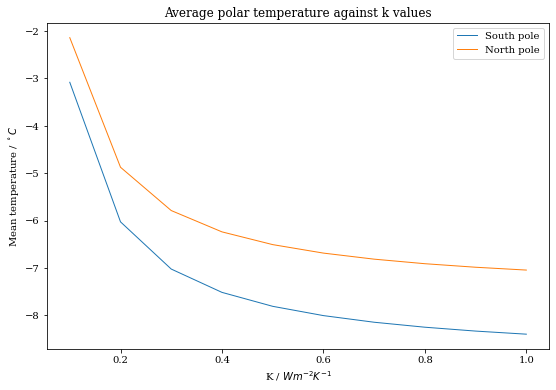

In [18]:
plt.title('Average polar temperature against k values')
plt.xlabel('K / $ W m^{-2} K^{-1}$')
plt.ylabel('Mean temperature / $^\circ C$')
plt.plot(k_values, [np.mean(transmission_temperature_series[i][1][0]) - 273.15 for i in range(len(k_values))], lw=1, label='South pole')
plt.plot(k_values, [np.mean(transmission_temperature_series[i][1][M]) - 273.15 for i in range(len(k_values))], lw=1, label='North pole')
plt.legend()
plt.savefig('average-polar-temp-v-k.png')

## Global Heat map

In [19]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge cartopy

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\BR\anaconda3

  added / updated specs:
    - cartopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cartopy-0.21.1             |   py39hb6e7958_0         1.6 MB
    conda-23.1.0               |   py39hcbf5309_0         912 KB  conda-forge
    geos-3.8.0                 |       h33f27b4_0         905 KB
    proj-8.0.1                 |       h1cfcee9_0         2.9 MB  conda-forge
    pyproj-3.3.1               |   py39ha996c60_1         448 KB  conda-forge
    pyshp-2.3.1                |     pyhd8ed1ab_0         941 KB  conda-forge
    ruamel.yaml-0.17.21        |   py39hb82d6ee_1         169 KB  conda-forge
    ruamel.yaml.clib-0.2.6     |   py39h2bbff1b_1         101 KB
    shapely-1.8.4              |   py39h9064783_0         364 KB
    -----------------------------------------------------

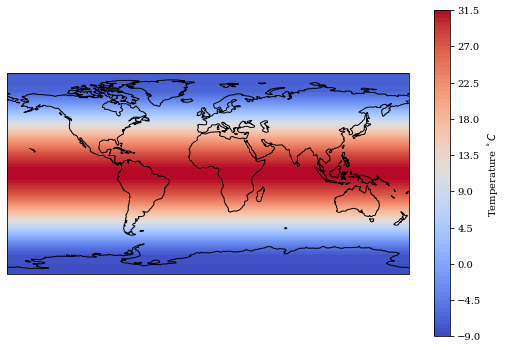

In [20]:
from cartopy import config
import cartopy.crs as ccrs



lats = latitude
lons = np.arange(-180, 187.2, 7.2)

temps = np.ones(shape=(M + 1, M + 1))

for i in range(M+1):
    for j in range(M+1):
        temps[i][j] = Tmp[i][3999]

plt.rcParams["figure.figsize"] = (9,6)        
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(lons, lats, temps - 273.15 , 90,
             transform=ccrs.PlateCarree(), cmap='coolwarm') # 'rainbow
plt.colorbar(label='Temperature $^\circ C$')

#plt.savefig('global-temp-distribution.png')

## IR transmission model

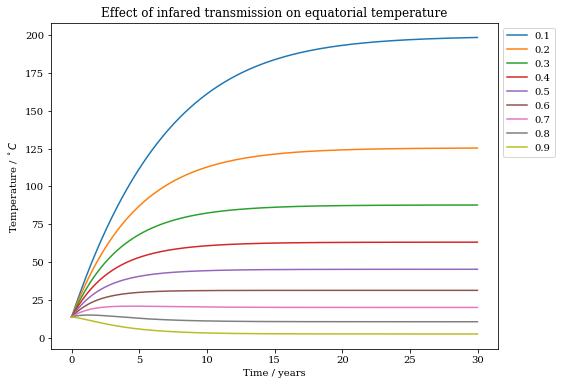

In [21]:
plt.rcParams["figure.figsize"] = (8,6)
plt.title('Effect of infared transmission on equatorial temperature')
plt.xlabel('Time / years')
plt.ylabel('Temperature / $^\circ C$')
for i in np.arange(0.1, 1.0, 0.1):
    plt.plot(time_series, temperature_time_series(_k = 0.5, _ir_trans = i)[int(M/2)] - 273.15, label=f'{round(i,1)}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('temperature-distributions-IR.png')

In [22]:
transmission_temperature_series = []
ir_values = np.arange(0.4,1.1,0.1)
for i in ir_values:
    transmission_temperature_series.append([i, temperature_time_series(_k=0.5, _ir_trans = i)])


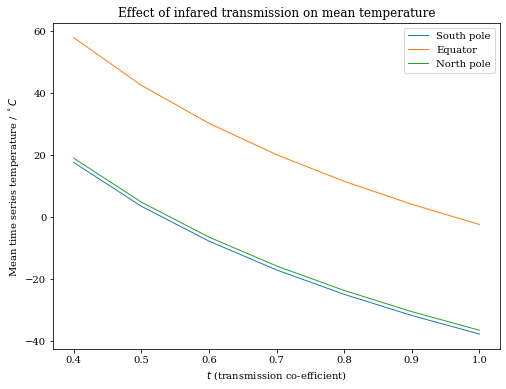

In [23]:
plt.title('Effect of infared transmission on mean temperature')
plt.xlabel('$t$ (transmission co-efficient)')
plt.ylabel('Mean time series temperature / $^\circ C$')
#for position in [0, int(M/2), M]:
plt.plot(ir_values, [np.mean(transmission_temperature_series[i][1][0]) - 273.15 for i in range(len(ir_values))], lw=1, label="South pole")
plt.plot(ir_values, [np.mean(transmission_temperature_series[i][1][int(M/2)]) - 273.15 for i in range(len(ir_values))], lw=1, label="Equator")
plt.plot(ir_values, [np.mean(transmission_temperature_series[i][1][M]) - 273.15 for i in range(len(ir_values))], lw=1, label="North pole")
plt.legend()
plt.savefig('mean temperature-IR.png')

In [24]:
model = LinearRegression().fit(ir_values.reshape((-1,1)), [np.mean(transmission_temperature_series[i][1][0]) - 273.15 for i in range(len(ir_values))])

In [25]:
model.score(ir_values.reshape((-1,1)), [np.mean(transmission_temperature_series[i][1][0]) - 273.15 for i in range(len(ir_values))])

0.9775044874215495

In [26]:
model.coef_

array([-90.78704368])

In [27]:
lr_temperatures = []
for m in range(M + 1):
    x = ir_values.reshape((-1,1))
    y = [np.mean(transmission_temperature_series[i][1][m]) - 273.15 for i in range(len(ir_values))]
    model = LinearRegression().fit(x, y)
    lr_temperatures.append([model.coef_, model.score(x, y)])

In [28]:
print(np.mean([lr_temperatures[i][0] for i in range(M)]))

-95.9147348352513


In [29]:
print(np.mean([lr_temperatures[i][1] for i in range(M)]))

0.9774777753142768


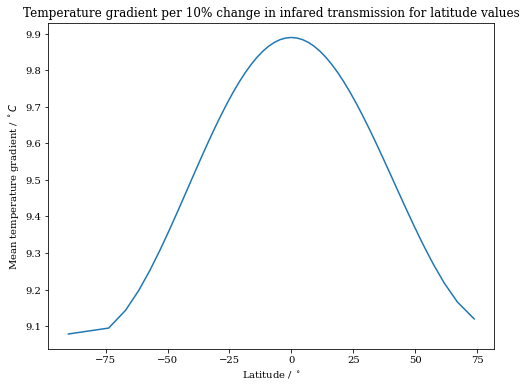

In [30]:
plt.title('Temperature gradient per 10% change in infared transmission for latitude values')
plt.ylabel('Mean temperature gradient / $^\circ C$')
plt.xlabel('Latitude / $^\circ $')
plt.plot(latitude[0:50], [lr_temperatures[i][0] * -(1/10) for i in range(M)])
plt.savefig('Temperature-grad-tau.png')